# ai with pytorch for detecting heart disease in humans

## import dependencies

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

## dataset stuff

### import dataset csv

In [3]:
df = pd.read_csv('dataset.csv')
df = df.sample(frac=1)

#show table
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,diagnosis
221,54,0,3,108,267,0,2,167,0,0.0,1,0.0,3.0,0
271,66,1,4,160,228,0,2,138,0,2.3,1,0.0,6.0,0
191,51,1,4,140,298,0,0,122,1,4.2,2,3.0,7.0,3
220,41,0,3,112,268,0,2,172,1,0.0,1,0.0,3.0,0
29,40,1,4,110,167,0,2,114,1,2.0,2,0.0,7.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,48,1,4,122,222,0,2,186,0,0.0,1,0.0,3.0,0
111,56,1,4,125,249,1,2,144,1,1.2,2,1.0,3.0,1
269,42,1,3,130,180,0,0,150,0,0.0,1,0.0,3.0,0
261,58,0,2,136,319,1,2,152,0,0.0,1,2.0,3.0,3


### train test split

In [4]:
ratio = 0.99
total_rows = df.shape[0]
train_size = int(total_rows*ratio)

# Split data into a test dataset and train dataset
train = df[0:train_size]
test = df[train_size:]

#convert to numpy arrays (so its autodiff compatible)
train_data = train.to_numpy()
test_data = test.to_numpy()

#check
print(df)

print(train)
print(test)

print(train_data)
print(test_data)

     age   sex   cp   trestbps   chol   fbs   restecg   thalach   exang  \
221   54     0    3        108    267     0         2       167       0   
271   66     1    4        160    228     0         2       138       0   
191   51     1    4        140    298     0         0       122       1   
220   41     0    3        112    268     0         2       172       1   
29    40     1    4        110    167     0         2       114       1   
..   ...   ...  ...        ...    ...   ...       ...       ...     ...   
99    48     1    4        122    222     0         2       186       0   
111   56     1    4        125    249     1         2       144       1   
269   42     1    3        130    180     0         0       150       0   
261   58     0    2        136    319     1         2       152       0   
126   56     0    4        200    288     1         2       133       1   

      oldpeak   slope   ca  thal   diagnosis  
221       0.0       1  0.0   3.0           0  
271  

## acc. ai stuff

### training

- using pytorch, numpy, and matplotlib (probably:) )
- using a high train test split ratio to get the best results

In [5]:
class SimpleNN(nn.Module): 
  def __init__(self): 
    super(SimpleNN, self).__init__() 
    self.fc1 = nn.Linear(13, 2)  # match 13 input features from your input
    self.relu = nn.ReLU()      # Activation function 
    self.fc2 = nn.Linear(2, 1)

  def forward(self, x): 
    x = self.fc1(x) 
    x = self.relu(x) 
    x = self.fc2(x) 
    return x 


In [6]:
model = SimpleNN() 

# outputs the struct. of the model
print(model) 

SimpleNN(
  (fc1): Linear(in_features=13, out_features=2, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)


In [7]:
# sample data for training
train.columns = train.columns.str.strip()               # clean column name
inputs = train.drop("diagnosis", axis=1)                # Drop target column
inputs = inputs.apply(pd.to_numeric, errors='coerce')   # Convert all values to numeric, set errors='coerce' to handle '?'
inputs = inputs.fillna(inputs.mean())  # Fill NaNs with 0, safer than fillna(0)
inputs = torch.tensor(inputs.values)

targets = torch.tensor(train["diagnosis"].values, dtype=torch.long)

In [8]:
train = train.apply(pd.to_numeric, errors='coerce').fillna(0)

In [9]:
#calculate mean squared error
criterion = nn.MSELoss() 
optimiser = optim.SGD(model.parameters(), lr=0.01) 

In [10]:
#check datatypes
print(f"inputs dtype: {inputs.dtype}")
print(f"targets dtype: {targets.dtype}")
print(f"model parameter dtype: {next(model.parameters()).dtype}")

# Remove samples where targets are NaN
#mask = ~torch.isnan(targets).squeeze()  # shape: (299,)
#inputs = inputs[mask]
#targets = targets[mask]

#sorting datatypes...
inputs = inputs.float()
targets = targets.float()
model = model.float()

# Make sure data types match
inputs = inputs.float()
targets = targets.float().view(-1, 1)  # Ensure shape matches model output

# Sanity check
print(inputs.dtype, targets.dtype)  # should both be float32
print(inputs.shape, targets.shape)  # e.g., [299, 13] and [299, 1]

lossls = []
epochls = []
outputls = []
i = 1

for epoch in range(1000):
    optimiser.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    if torch.isnan(loss):
        print("Loss is NaN!")
        break
    loss.backward()
    optimiser.step()
    
    print(f'Epoch [{epoch + 1}/1000], Loss: {loss.item():.4f}')
    
    lossls.append(loss.item())
    outputls.append(outputs.mean().item())  # You could also use outputs[0].item() for first prediction
    epochls.append(i)
    i += 1

inputs dtype: torch.float64
targets dtype: torch.int64
model parameter dtype: torch.float32
torch.float32 torch.float32
torch.Size([299, 13]) torch.Size([299, 1])
Epoch [1/1000], Loss: 246.7353
Epoch [2/1000], Loss: 2.3724
Epoch [3/1000], Loss: 2.3376
Epoch [4/1000], Loss: 2.3041
Epoch [5/1000], Loss: 2.2720
Epoch [6/1000], Loss: 2.2411
Epoch [7/1000], Loss: 2.2115
Epoch [8/1000], Loss: 2.1831
Epoch [9/1000], Loss: 2.1557
Epoch [10/1000], Loss: 2.1295
Epoch [11/1000], Loss: 2.1043
Epoch [12/1000], Loss: 2.0801
Epoch [13/1000], Loss: 2.0568
Epoch [14/1000], Loss: 2.0345
Epoch [15/1000], Loss: 2.0130
Epoch [16/1000], Loss: 1.9924
Epoch [17/1000], Loss: 1.9727
Epoch [18/1000], Loss: 1.9537
Epoch [19/1000], Loss: 1.9354
Epoch [20/1000], Loss: 1.9179
Epoch [21/1000], Loss: 1.9011
Epoch [22/1000], Loss: 1.8849
Epoch [23/1000], Loss: 1.8694
Epoch [24/1000], Loss: 1.8545
Epoch [25/1000], Loss: 1.8402
Epoch [26/1000], Loss: 1.8264
Epoch [27/1000], Loss: 1.8132
Epoch [28/1000], Loss: 1.8005
Epoc

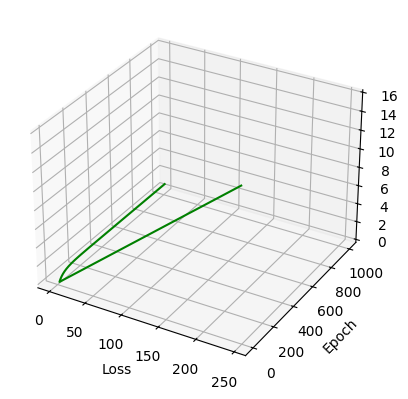

In [11]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(lossls, epochls, outputls, 'green')
ax.set_xlabel("Loss")
ax.set_ylabel("Epoch")
ax.set_zlabel("Output")
plt.show()